This notebook experiments with constructing different sets of noise

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from src.bluenoise import generate_blue_noise_texture, filter_void_and_cluster_blue_noise_textures
from src.bluenoise import poisson_disc_scipy, poisson_disc_scipy_pixel_dist
from src.noise import generate_coloured_noise, generate_phase_only_noise, analyze_power_spectrum, measure_high_frequency_power
from src.noise import plot_2d_spectrum, plot_radial_spectrum
from src.noise import create_grayscale_ramp, dither_with_noise, dither_with_noise2
from src.noise import normalize_to_unit_range, plot_two_ramps_vertical, create_gray_image
from src.noise import white_noise_from_reference_moments2

## Some of the cells showing off blue noise spectrums below do not show spatially distributed blue noise, only the power distrubutions.

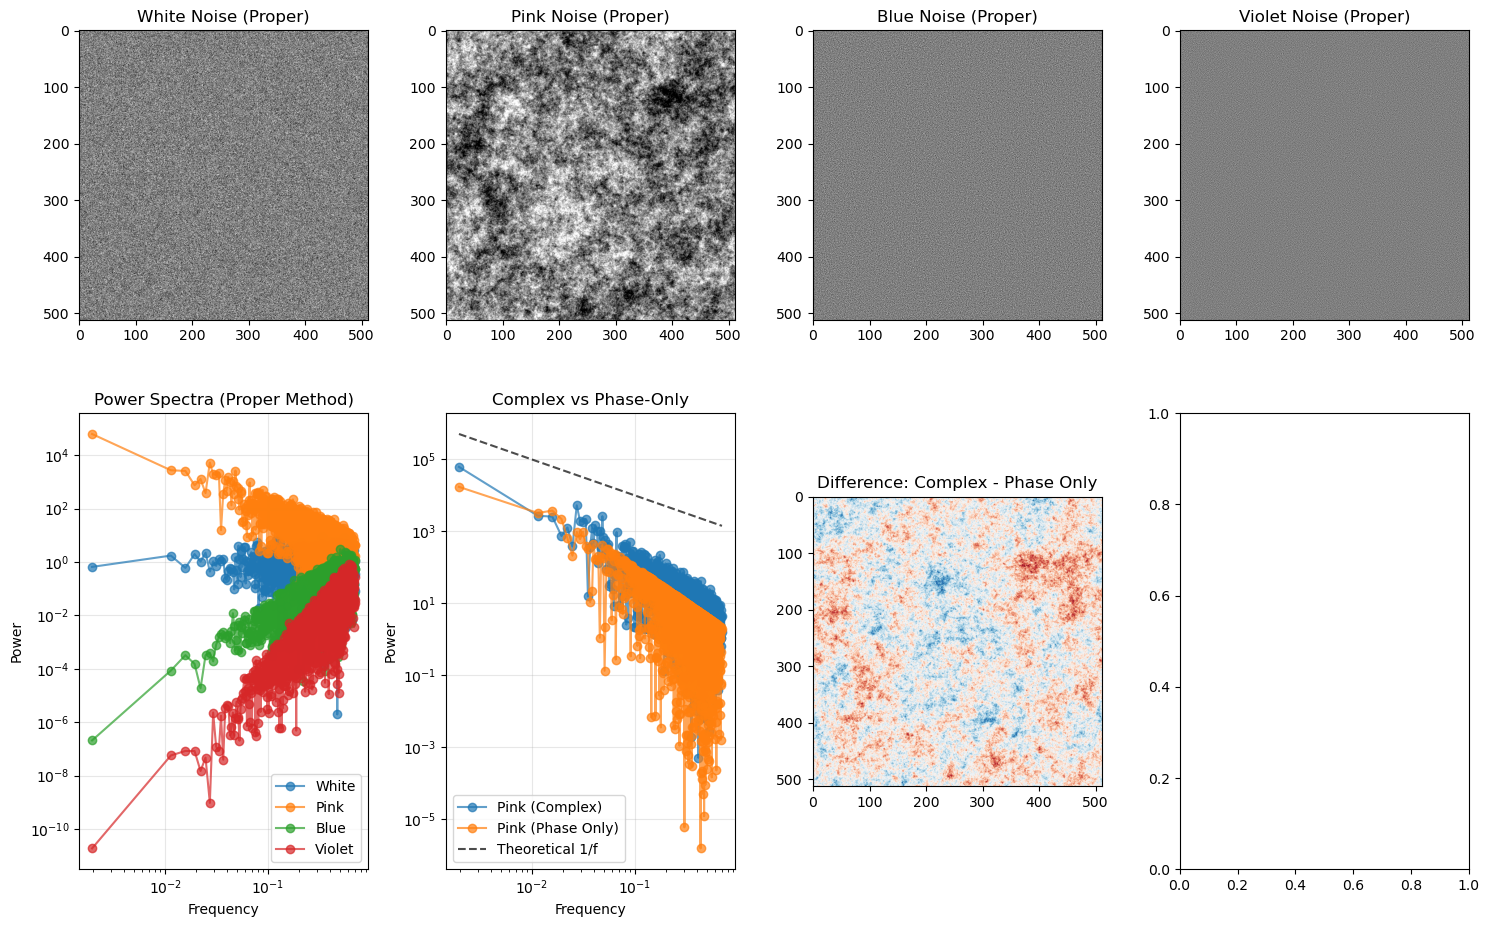

Standard deviations (showing relative power):
White: 0.0019524923553541859
Pink:  0.010918350212488239
Blue:  0.0007983368041238714
violet:  0.00038524886638131747
Pink (phase only): 0.008

High-frequency power (higher = more fine details):
White:  0.7170534630086512
Pink:   1.7434412030763144e-07
Blue:   0.922527709829433
Violet: 0.9804187233611656


In [9]:
# Define some noise parameters
def white_spectrum(f):
    return np.ones_like(f)

def blue_spectrum(f):
	return f

def pink_spectrum(f):
	f_safe = np.maximum(f, 1e-6)
	return 1 / f_safe

def violet_spectrum(f):
	return f ** 2

shape = (512, 512)
#phase = np.random.rand(shape[0], shape[1]) * 2 * np.pi

#white_noise = generate_white_noise(phase)
#blue_noise = generate_coloured_noise(shape, phase, blue_spectrum)
#pink_noise = generate_coloured_noise(shape, phase, pink_spectrum)
#violet_noise = generate_coloured_noise(shape, phase, violet_spectrum)

np.random.seed(42)  # For reproducibility

# Proper complex method
white_proper = generate_coloured_noise(shape, white_spectrum)
pink_proper = generate_coloured_noise(shape, pink_spectrum)
blue_proper = generate_coloured_noise(shape, blue_spectrum)
violet_proper = generate_coloured_noise(shape, violet_spectrum)

# Phase-only method (your original)
pink_phase_only = generate_phase_only_noise(shape, pink_spectrum)

# Analyze power spectra
f_white, p_white = analyze_power_spectrum(white_proper)
f_pink, p_pink = analyze_power_spectrum(pink_proper)
f_blue, p_blue = analyze_power_spectrum(blue_proper)
f_violet, p_violet = analyze_power_spectrum(violet_proper)
f_pink_phase, p_pink_phase = analyze_power_spectrum(pink_phase_only)

# Create comparison plot
fig, axes = plt.subplots(2, 4, figsize=(15, 10))

# Visual comparison
axes[0, 0].imshow(white_proper, cmap='gray', vmin=-3*np.std(white_proper), vmax=3*np.std(white_proper))
axes[0, 0].set_title('White Noise (Proper)')
vmin_pink = np.percentile(pink_proper, 1)
vmax_pink = np.percentile(pink_proper, 99)
axes[0, 1].imshow(pink_proper, cmap='gray', vmin=vmin_pink, vmax=vmax_pink)
axes[0, 1].set_title('Pink Noise (Proper)')
axes[0, 2].imshow(blue_proper, cmap='gray', vmin=-3*np.std(blue_proper), vmax=3*np.std(blue_proper))
axes[0, 2].set_title('Blue Noise (Proper)')
axes[0, 3].imshow(violet_proper, cmap='gray', vmin=-3*np.std(violet_proper), vmax=3*np.std(violet_proper))
axes[0, 3].set_title('Violet Noise (Proper)')


# Power spectrum comparison
axes[1, 0].loglog(f_white[::100], p_white[::100], 'o-', alpha=0.7, label='White')
axes[1, 0].loglog(f_pink[::100], p_pink[::100], 'o-', alpha=0.7, label='Pink')
axes[1, 0].loglog(f_blue[::100], p_blue[::100], 'o-', alpha=0.7, label='Blue')
axes[1, 0].loglog(f_violet[::100], p_violet[::100], 'o-', alpha=0.7, label='Violet')

axes[1, 0].set_xlabel('Frequency')
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('Power Spectra (Proper Method)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Theoretical vs actual comparison for pink noise
axes[1, 1].loglog(f_pink[::100], p_pink[::100], 'o-', alpha=0.7, label='Pink (Complex)')
axes[1, 1].loglog(f_pink_phase[::100], p_pink_phase[::100], 'o-', alpha=0.7, label='Pink (Phase Only)')
# Theoretical 1/f line
f_theory = f_pink[::100]
p_theory = 1000 / f_theory  # Scaled for visibility
axes[1, 1].loglog(f_theory, p_theory, 'k--', alpha=0.7, label='Theoretical 1/f')
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('Complex vs Phase-Only')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Show visual difference between methods
axes[1, 2].imshow(pink_proper - pink_phase_only, cmap='RdBu')
axes[1, 2].set_title('Difference: Complex - Phase Only')

plt.tight_layout()
plt.show()

# Print some statistics
print("Standard deviations (showing relative power):")
print(f"White: {np.std(white_proper)}")
print(f"Pink:  {np.std(pink_proper)}")
print(f"Blue:  {np.std(blue_proper)}")
print(f"violet:  {np.std(violet_proper)}")

print(f"Pink (phase only): {np.std(pink_phase_only):.3f}")


print("\nHigh-frequency power (higher = more fine details):")
print(f"White:  {measure_high_frequency_power(white_proper)}")
print(f"Pink:   {measure_high_frequency_power(pink_proper)}")
print(f"Blue:   {measure_high_frequency_power(blue_proper)}")
print(f"Violet: {measure_high_frequency_power(violet_proper)}")




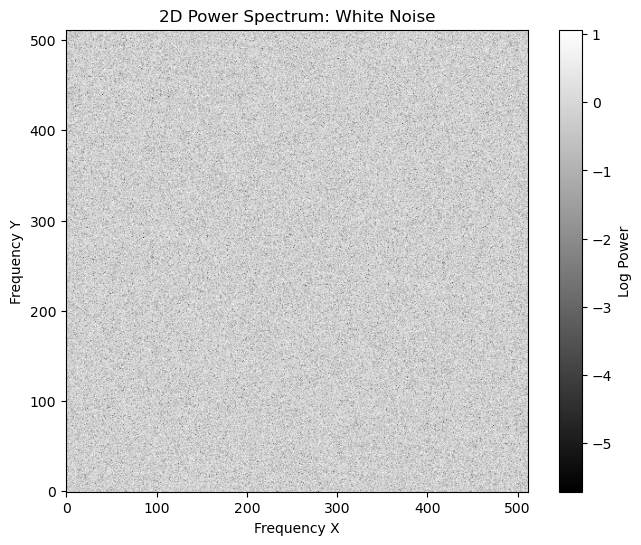

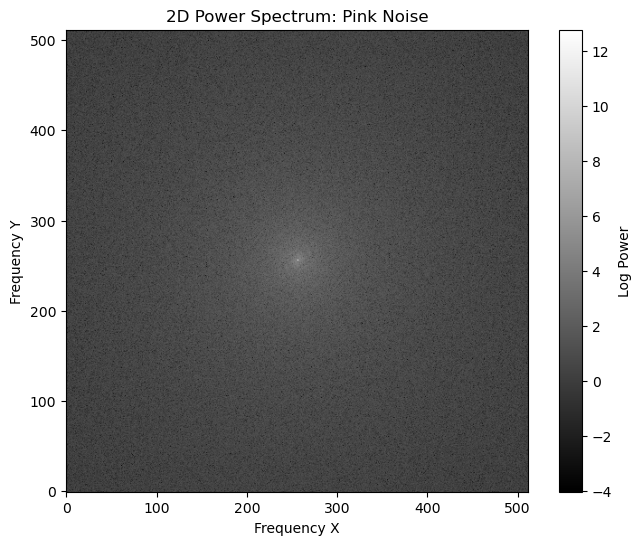

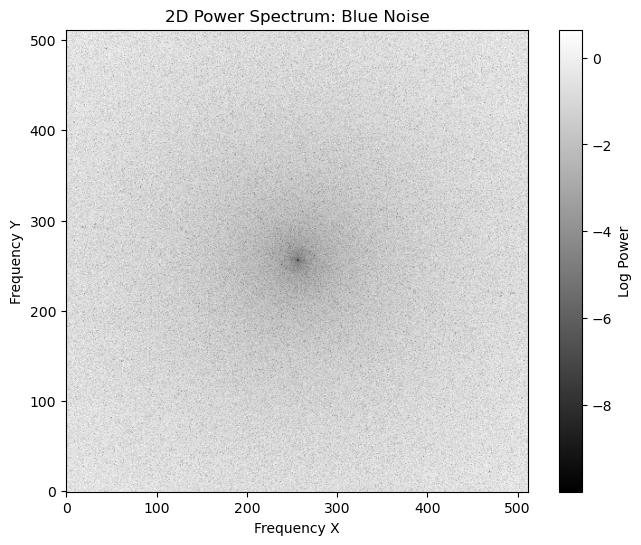

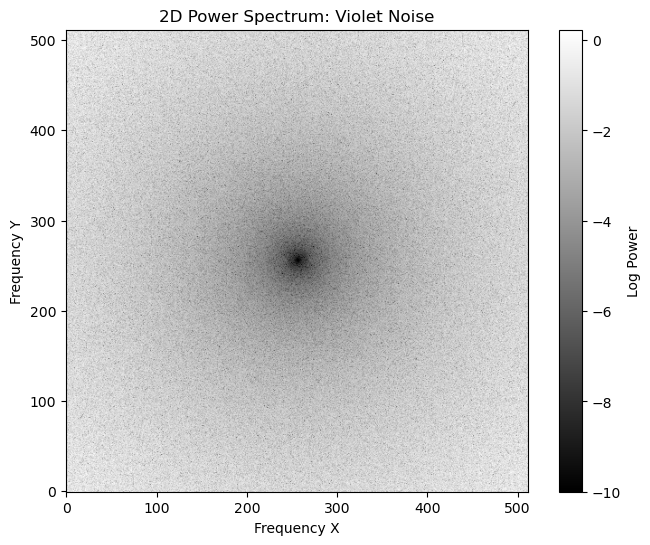

In [10]:
# Plot spectra for each noise type
plot_2d_spectrum(white_proper, "White Noise")
plot_2d_spectrum(pink_proper, "Pink Noise") 
plot_2d_spectrum(blue_proper, "Blue Noise")
plot_2d_spectrum(violet_proper, "Violet Noise")


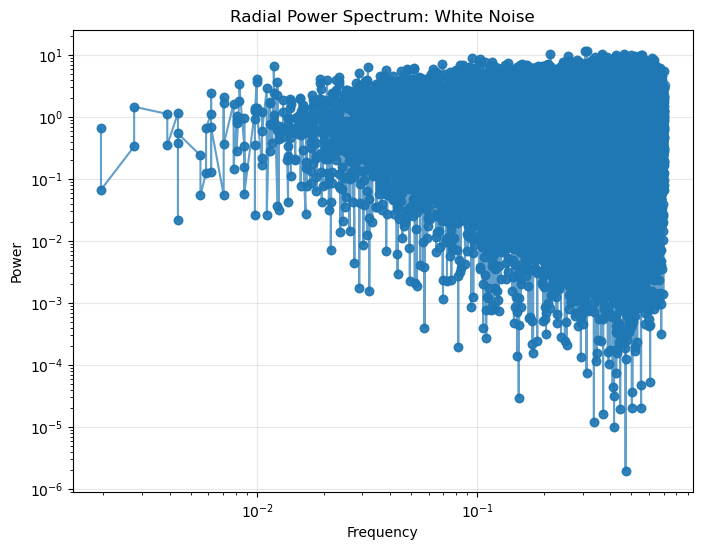

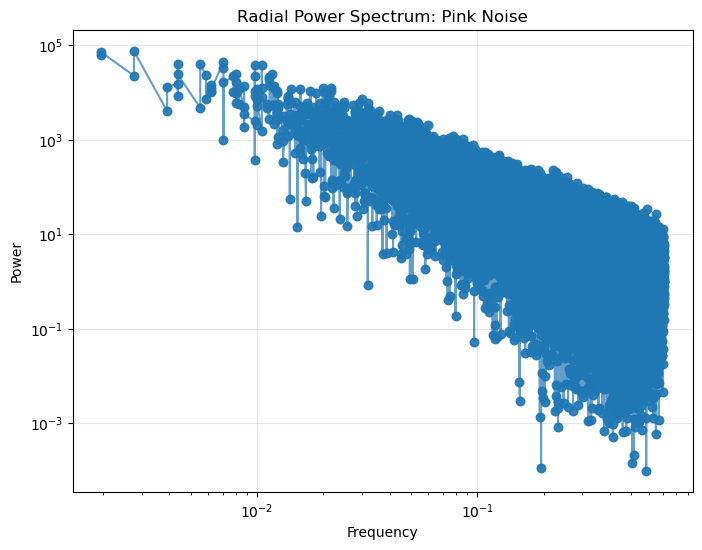

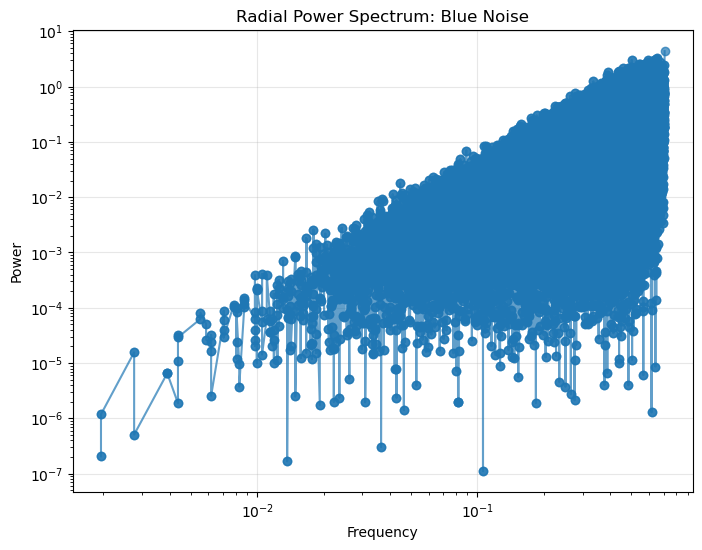

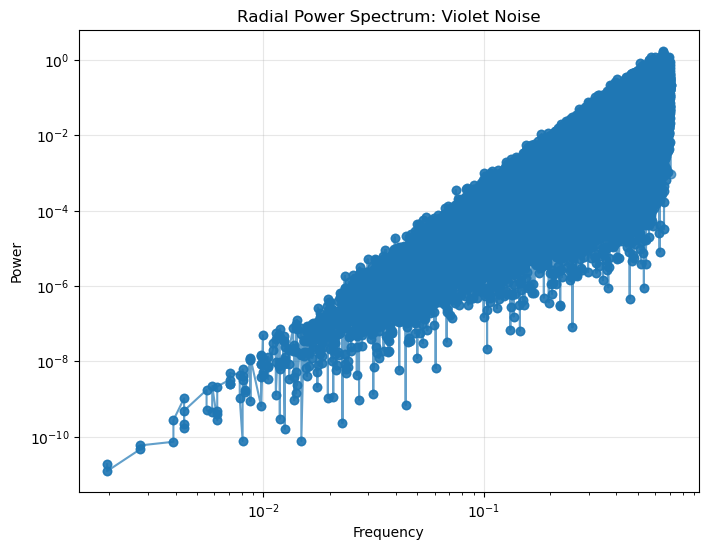

In [11]:
# Plot for each noise type
plot_radial_spectrum(white_proper, "White Noise")
plot_radial_spectrum(pink_proper, "Pink Noise")
plot_radial_spectrum(blue_proper, "Blue Noise") 
plot_radial_spectrum(violet_proper, "Violet Noise")


Now we can look at dithering te different types of noise textures

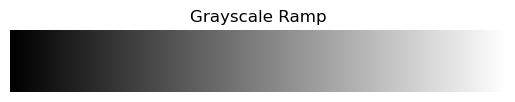

In [12]:
shape = (128, 1024) # np scaling
linear_ramp = create_grayscale_ramp(shape)
plt.imshow(linear_ramp, cmap='gray', vmin=0.0, vmax=1.0)
plt.title("Grayscale Ramp")
plt.axis('off')
plt.show()


[[ 4.35752555e-03  6.34530527e-03  1.74595540e-03 ...  4.77466961e-05
  -5.73050013e-04  5.97785245e-04]
 [ 2.77945935e-03 -3.40297232e-03 -3.48046123e-03 ... -5.92346807e-04
  -2.63539338e-03 -4.08298240e-04]
 [ 1.30087573e-03 -2.50309516e-03  2.99001612e-03 ... -1.21801233e-03
  -2.41694183e-03 -3.34594432e-03]
 ...
 [-3.33577797e-03 -5.32694040e-03  1.88006651e-03 ... -2.11603161e-03
   2.62419240e-03 -2.96635630e-03]
 [ 2.60774585e-03  1.23788298e-03  6.87398152e-04 ...  3.36614331e-03
  -1.91132418e-03  2.03711050e-03]
 [-2.41751048e-03 -4.01497070e-03  2.18384949e-03 ... -1.71256056e-03
   1.05535817e-03 -4.15786080e-03]]


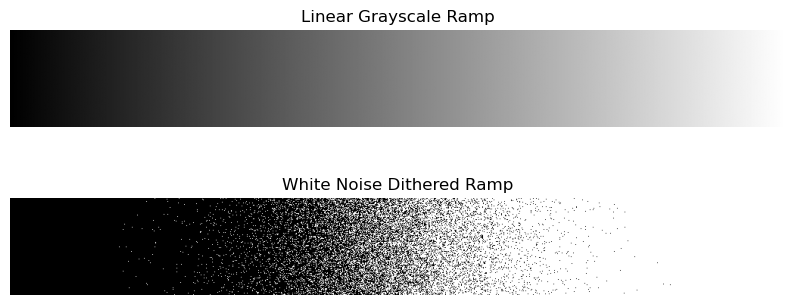

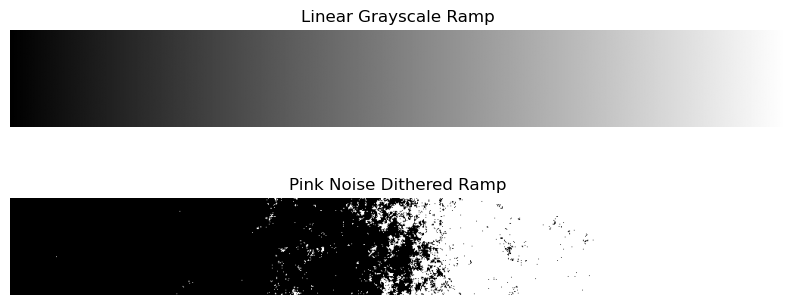

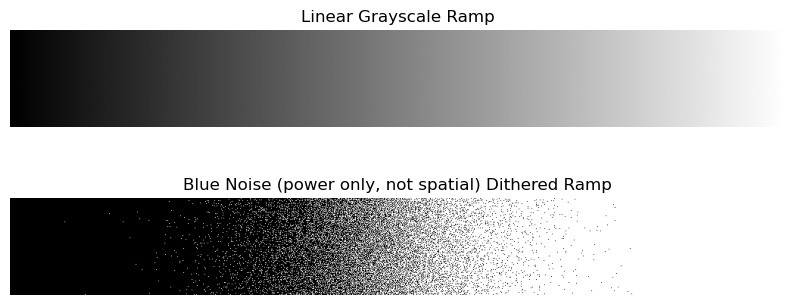

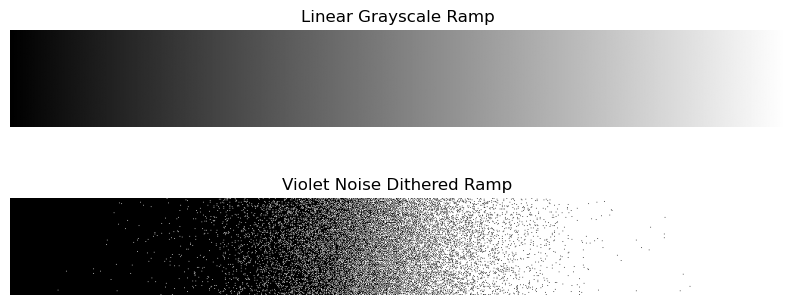

In [13]:
white_noise_ramp = generate_coloured_noise(shape, white_spectrum)
pink_noise_ramp = generate_coloured_noise(shape, pink_spectrum)
blue_noise_ramp = generate_coloured_noise(shape, blue_spectrum)
violet_noise_ramp = generate_coloured_noise(shape, violet_spectrum)


white_noise_normalized = normalize_to_unit_range(white_noise_ramp)
pink_noise_normalized = normalize_to_unit_range(pink_noise_ramp)
blue_noise_normalized = normalize_to_unit_range(blue_noise_ramp)
violet_noise_normalized = normalize_to_unit_range(violet_noise_ramp)

white_dithered_ramp = dither_with_noise(linear_ramp, white_noise_normalized)
pink_dithered_ramp = dither_with_noise(linear_ramp, pink_noise_normalized)
blue_dithered_ramp = dither_with_noise(linear_ramp, blue_noise_normalized)
violet_dithered_ramp = dither_with_noise(linear_ramp, violet_noise_normalized)


plot_two_ramps_vertical(linear_ramp, white_dithered_ramp, "Linear Grayscale Ramp", "White Noise Dithered Ramp")
plot_two_ramps_vertical(linear_ramp, pink_dithered_ramp, "Linear Grayscale Ramp", "Pink Noise Dithered Ramp")
plot_two_ramps_vertical(linear_ramp, blue_dithered_ramp, "Linear Grayscale Ramp", "Blue Noise (power only, not spatial) Dithered Ramp")
plot_two_ramps_vertical(linear_ramp, violet_dithered_ramp, "Linear Grayscale Ramp", "Violet Noise Dithered Ramp")


print(white_noise_ramp)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

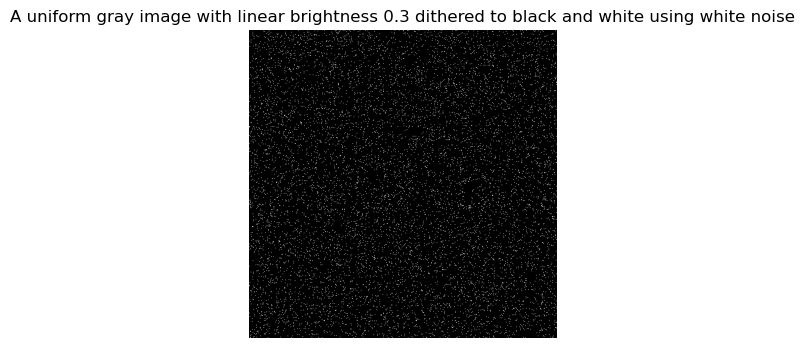

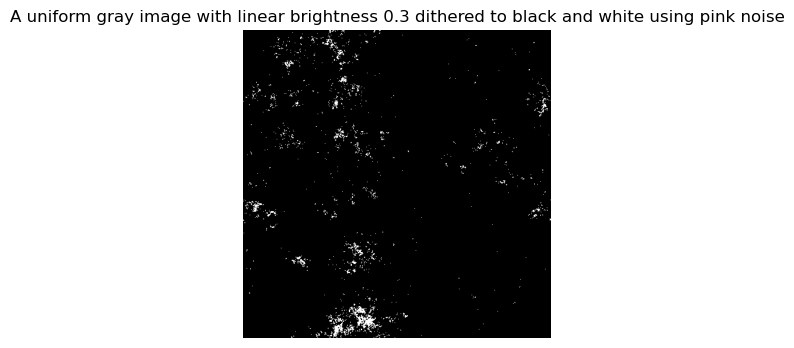

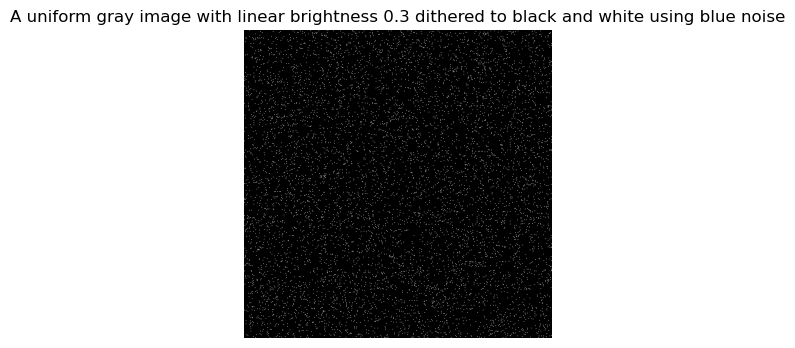

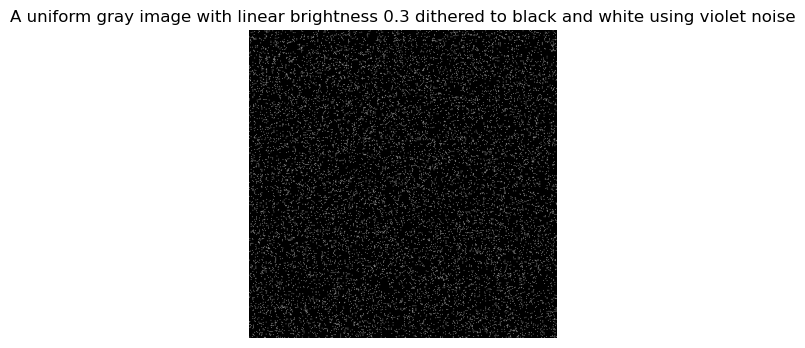

In [14]:
shape = (512, 512)
gray_point3 = create_gray_image(shape, 0.3)
white_noise = generate_coloured_noise(shape, white_spectrum)
pink_noise = generate_coloured_noise(shape, pink_spectrum)
blue_noise = generate_coloured_noise(shape, blue_spectrum)
violet_noise = generate_coloured_noise(shape, violet_spectrum)


white_noise_normalized = normalize_to_unit_range(white_noise)
pink_noise_normalized = normalize_to_unit_range(pink_noise)
blue_noise_normalized = normalize_to_unit_range(blue_noise)
violet_noise_normalized = normalize_to_unit_range(violet_noise)

white_dithered = dither_with_noise(gray_point3, white_noise_normalized)
pink_dithered = dither_with_noise(gray_point3, pink_noise_normalized)
blue_dithered = dither_with_noise(gray_point3, blue_noise_normalized)
violet_dithered = dither_with_noise(gray_point3, violet_noise_normalized)

plt.figure(figsize=(8, 4))
plt.imshow(white_dithered, cmap='gray', vmin=0.0, vmax=1.0)
plt.title("A uniform gray image with linear brightness 0.3 dithered to black and white using white noise")
plt.axis('off')


plt.figure(figsize=(8, 4))
plt.imshow(pink_dithered, cmap='gray', vmin=0.0, vmax=1.0)
plt.title("A uniform gray image with linear brightness 0.3 dithered to black and white using pink noise")
plt.axis('off')


plt.figure(figsize=(8, 4))
plt.imshow(blue_dithered, cmap='gray', vmin=0.0, vmax=1.0)
plt.title("A uniform gray image with linear brightness 0.3 dithered to black and white using blue noise")
plt.axis('off')


plt.figure(figsize=(8, 4))
plt.imshow(violet_dithered, cmap='gray', vmin=0.0, vmax=1.0)
plt.title("A uniform gray image with linear brightness 0.3 dithered to black and white using violet noise")
plt.axis('off')


In [15]:
# Generate a random 512x512 to save
white_noise_ramp = generate_coloured_noise((512, 512), white_spectrum)


### The next cell will generate a bunch of different example white noises at 64x64 and save them.
However, we need to match the overall brightness of the textures.

i, (white mean, white std), (blue mean, blue std)
0, (125.83837890625, 73.89896734539533), (127.5, 73.90027063549903)
1, (127.607666015625, 73.91227598201519), (127.5, 73.90027063549903)
2, (126.119140625, 73.90719122579665), (127.5, 73.90027063549903)
3, (125.830078125, 73.90691023485319), (127.5, 73.90027063549903)
4, (127.242431640625, 73.66017481551852), (127.5, 73.90027063549903)
5, (127.71630859375, 73.9005883643173), (127.5, 73.90027063549903)
6, (128.142333984375, 73.88792389611118), (127.5, 73.90027063549903)
7, (126.39599609375, 73.90147264939979), (127.5, 73.90027063549903)


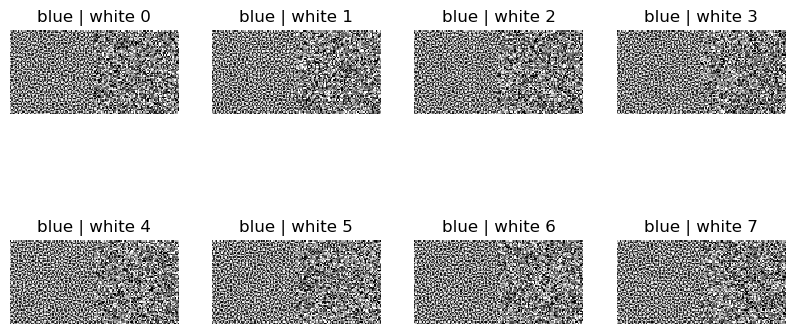

In [4]:
from src.noise import white_noise_from_reference_moments2

outpath = "textures/white_noise/64x64"
os.makedirs(outpath, exist_ok=True)

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
shape = (64, 64)

print("i, (white mean, white std), (blue mean, blue std)")

for i in range(8):
	out_path = os.path.join(outpath, f"{i}.png")
	ref_path = f"textures/bluenoise_filterinput/{i}.png"

	img_white = white_noise_from_reference_moments2(ref_path, out_path, shape=(64,64), seed=i)

	# load the reference blue noise as grayscale
	img_blue = cv2.imread(ref_path, cv2.IMREAD_GRAYSCALE)

	# plot side-by-side inside each subplot
	r, c = divmod(i, 4)
	ax = axes[r, c]

	# concatenate horizontally for visualization
	both = np.concatenate([img_blue, img_white], axis=1)
	ax.imshow(both, cmap="gray", interpolation="nearest")
	ax.set_title(f"blue | white {i}")
	ax.axis("off")

	print(f"{i}, ({img_white.mean()}, {img_white.std()}), ({img_blue.mean()}, {img_blue.std()})")

	cv2.imwrite(out_path, img_white)


### This cell will generate a bunch of different examples of white noises at 1024x1024 and save them


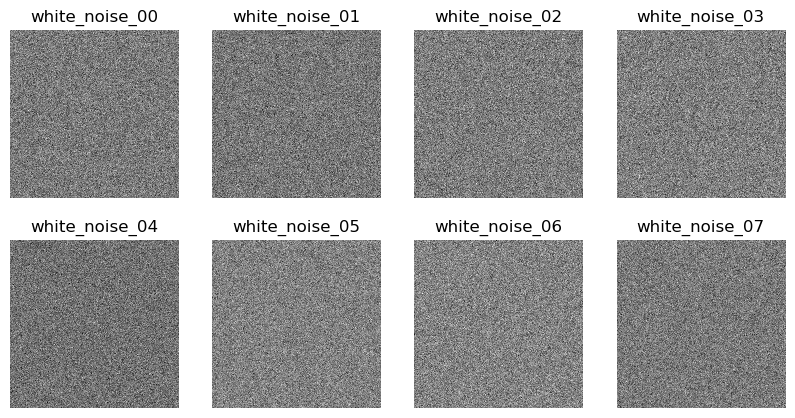

In [17]:
outpath = "textures/white_noise/1024x1024"
fig, axes = plt.subplots(2, 4, figsize=(10, 5))  # 2 rows, 4 cols
shape = (1024, 1024)

for i in range(0, 8):
	white_noise = generate_coloured_noise(shape, white_spectrum)
	white_noise_uint8 = cv2.normalize(
		white_noise, None, 0, 255, cv2.NORM_MINMAX
	).astype('uint8')

	# pick subplot without enumerate()
	r, c = divmod(i, 4)         # row, col
	ax = axes[r, c]
	ax.imshow(white_noise, cmap="gray", interpolation="nearest")
	ax.set_title(f"white_noise_{i:02d}")
	ax.axis("off")

	# save with different names
	cv2.imwrite(os.path.join(outpath, f"white_noise_{i:02d}.png"), white_noise_uint8)


In [5]:
import os
import cv2
import numpy as np

def make_tiled_versions_cv2(
	input_dir="textures/bluenoise_filterinput",
	output_dir="textures/bluenoise_filterinput_tiled",
	out_size=1024,
	names=tuple(str(i) for i in range(8)),
	):
	"""
	Reads <name>.png from input_dir and writes a 1024x1024 tiled PNG to output_dir.
	Uses OpenCV only (no PIL/pathlib). Preserves channel count:
		- 1 channel (grayscale)
		- 3 channels (BGR)
		- 4 channels (BGRA with alpha)
	Tiling repeats the source at native pixel size. If source exceeds 1024, it is cropped.
	"""
	os.makedirs(output_dir, exist_ok=True)

	for name in names:
		src_path = os.path.join(input_dir, f"{name}.png")
		if not os.path.exists(src_path):
			print(f"Skipping {src_path} (not found).")
			continue

		# Keep channels as-is (grayscale/BGR/BGRA)
		tile = cv2.imread(src_path, cv2.IMREAD_UNCHANGED)
		if tile is None:
			print(f"Skipping {src_path} (could not read).")
			continue

		h, w = tile.shape[:2]
		if h == 0 or w == 0:
			print(f"Skipping {src_path} (empty image).")
			continue

		# Determine channel count
		channels = 1 if tile.ndim == 2 else tile.shape[2]

		# Prepare blank canvas matching tile dtype & channels
		if channels == 1:
			canvas = np.zeros((out_size, out_size), dtype=tile.dtype)
		else:
			canvas = np.zeros((out_size, out_size, channels), dtype=tile.dtype)

		# Tile copy (handles partial tiles at edges via min())
		y = 0
		while y < out_size:
			x = 0
			h_copy = min(h, out_size - y)
			while x < out_size:
				w_copy = min(w, out_size - x)
				if channels == 1:
					canvas[y:y+h_copy, x:x+w_copy] = tile[0:h_copy, 0:w_copy]
				else:
					canvas[y:y+h_copy, x:x+w_copy, :] = tile[0:h_copy, 0:w_copy, :]
				x += w
			y += h
		outname = "tiled" + name
		out_path = os.path.join(output_dir, f"{outname}.png")
		ok = cv2.imwrite(out_path, canvas) 
		if ok:
			print(f"Wrote {out_path}")
		else:
			print(f"Failed to write {out_path}")

# Example:
make_tiled_versions_cv2()



Wrote textures/bluenoise_filterinput_tiled\tiled0.png
Wrote textures/bluenoise_filterinput_tiled\tiled1.png
Wrote textures/bluenoise_filterinput_tiled\tiled2.png
Wrote textures/bluenoise_filterinput_tiled\tiled3.png
Wrote textures/bluenoise_filterinput_tiled\tiled4.png
Wrote textures/bluenoise_filterinput_tiled\tiled5.png
Wrote textures/bluenoise_filterinput_tiled\tiled6.png
Wrote textures/bluenoise_filterinput_tiled\tiled7.png


### Generate tiled versions of the moment-matched white noise textures.

In [19]:
make_tiled_versions_cv2(
	input_dir = "textures/white_noise/64x64/",
	output_dir = "textures/white_noise/1024x1024_tiled/",
	out_size = 1024,
	names = tuple(str(i) for i in range(8)),
)

Wrote textures/white_noise/1024x1024_tiled/tiled0.png
Wrote textures/white_noise/1024x1024_tiled/tiled1.png
Wrote textures/white_noise/1024x1024_tiled/tiled2.png
Wrote textures/white_noise/1024x1024_tiled/tiled3.png
Wrote textures/white_noise/1024x1024_tiled/tiled4.png
Wrote textures/white_noise/1024x1024_tiled/tiled5.png
Wrote textures/white_noise/1024x1024_tiled/tiled6.png
Wrote textures/white_noise/1024x1024_tiled/tiled7.png


The versions above all generate pretty tightly packed pixels. At far distances, they blend very much together towards a more uniform gray. 

Instead of that, lets blow everything up so it's more easy to see the "pixels" at far distances. 1024 / 64 = 16, so blow up each pixel by 16x. -- ie, make each 1 pixel now take up a 16x16 region of pixels.

In [6]:
def make_pixel_scaled_versions_cv2(
    input_dir="textures/bluenoise_filterinput",
    output_dir="textures/bluenoise_filterinput/blowups_1024x1024",
    in_size = 64,
    out_size=1024,
    names=tuple(str(i) for i in range(8)),
):
    os.makedirs(output_dir, exist_ok=True)

    for name in names:
        src_path = os.path.join(input_dir, f"{name}.png")
        if not os.path.exists(src_path):
            print(f"Skipping {src_path} (not found).")
            continue

        img = cv2.imread(src_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            print(f"Skipping {src_path} (could not read).")
            continue

        h, w = img.shape[:2]

        # Compute integer factor relative to declared in_size
        fx = out_size // in_size
        fy = out_size // in_size

        if out_size % in_size == 0 and h == in_size and w == in_size:
            # Exact pixel repeat
            if img.ndim == 2:  # grayscale
                up = np.repeat(np.repeat(img, fy, axis=0), fx, axis=1)
            else:
                up = np.repeat(np.repeat(img, fy, axis=0), fx, axis=1)
        else:
            # Generic nearest-neighbor resize if dimensions differ
            up = cv2.resize(img, (out_size, out_size), interpolation=cv2.INTER_NEAREST)
            print(f"{src_path}: used cv2.resize (non-standard in/out sizes)")

        out_path = os.path.join(output_dir, f"{name}.png")
        ok = cv2.imwrite(out_path, up)
        if ok:
            print(f"Wrote {out_path} ({w}x{h} -> {out_size}x{out_size})")
        else:
            print(f"Failed to write {out_path}")

make_pixel_scaled_versions_cv2()

Wrote textures/bluenoise_filterinput/blowups_1024x1024\0.png (64x64 -> 1024x1024)
Wrote textures/bluenoise_filterinput/blowups_1024x1024\1.png (64x64 -> 1024x1024)
Wrote textures/bluenoise_filterinput/blowups_1024x1024\2.png (64x64 -> 1024x1024)
Wrote textures/bluenoise_filterinput/blowups_1024x1024\3.png (64x64 -> 1024x1024)
Wrote textures/bluenoise_filterinput/blowups_1024x1024\4.png (64x64 -> 1024x1024)
Wrote textures/bluenoise_filterinput/blowups_1024x1024\5.png (64x64 -> 1024x1024)
Wrote textures/bluenoise_filterinput/blowups_1024x1024\6.png (64x64 -> 1024x1024)
Wrote textures/bluenoise_filterinput/blowups_1024x1024\7.png (64x64 -> 1024x1024)


Now we can load the white noise textures and make some scaled versions of those.

In [9]:
make_pixel_scaled_versions_cv2(input_dir = "textures/white_noise/64x64", output_dir = "textures/white_noise/blowups_1024x1024", in_size = 64, out_size = 1024)

Wrote textures/white_noise/blowups_1024x1024\0.png (64x64 -> 1024x1024)
Wrote textures/white_noise/blowups_1024x1024\1.png (64x64 -> 1024x1024)
Wrote textures/white_noise/blowups_1024x1024\2.png (64x64 -> 1024x1024)
Wrote textures/white_noise/blowups_1024x1024\3.png (64x64 -> 1024x1024)
Wrote textures/white_noise/blowups_1024x1024\4.png (64x64 -> 1024x1024)
Wrote textures/white_noise/blowups_1024x1024\5.png (64x64 -> 1024x1024)
Wrote textures/white_noise/blowups_1024x1024\6.png (64x64 -> 1024x1024)
Wrote textures/white_noise/blowups_1024x1024\7.png (64x64 -> 1024x1024)


## Now we need to generate dithered images of the white and blue noises

Wrote textures/bluenoise_filterinput/dither_point1\0.png
Wrote textures/bluenoise_filterinput/dither_point1\1.png
Wrote textures/bluenoise_filterinput/dither_point1\2.png
Wrote textures/bluenoise_filterinput/dither_point1\3.png
Wrote textures/bluenoise_filterinput/dither_point1\4.png
Wrote textures/bluenoise_filterinput/dither_point1\5.png
Wrote textures/bluenoise_filterinput/dither_point1\6.png
Wrote textures/bluenoise_filterinput/dither_point1\7.png


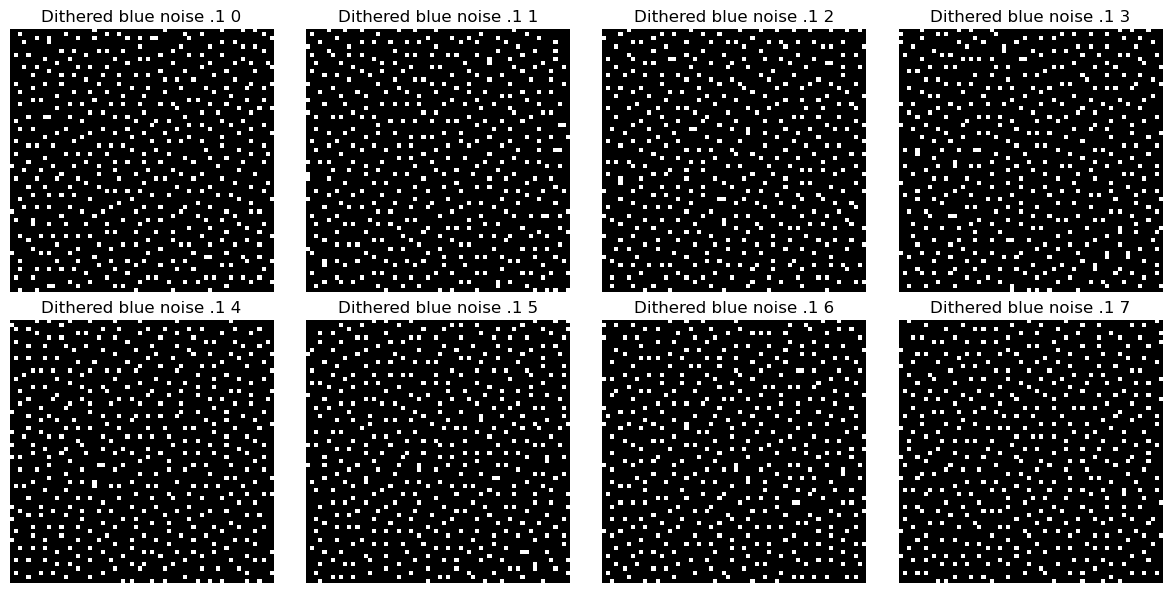

Wrote textures/bluenoise_filterinput/dither_point3\0.png
Wrote textures/bluenoise_filterinput/dither_point3\1.png
Wrote textures/bluenoise_filterinput/dither_point3\2.png
Wrote textures/bluenoise_filterinput/dither_point3\3.png
Wrote textures/bluenoise_filterinput/dither_point3\4.png
Wrote textures/bluenoise_filterinput/dither_point3\5.png
Wrote textures/bluenoise_filterinput/dither_point3\6.png
Wrote textures/bluenoise_filterinput/dither_point3\7.png


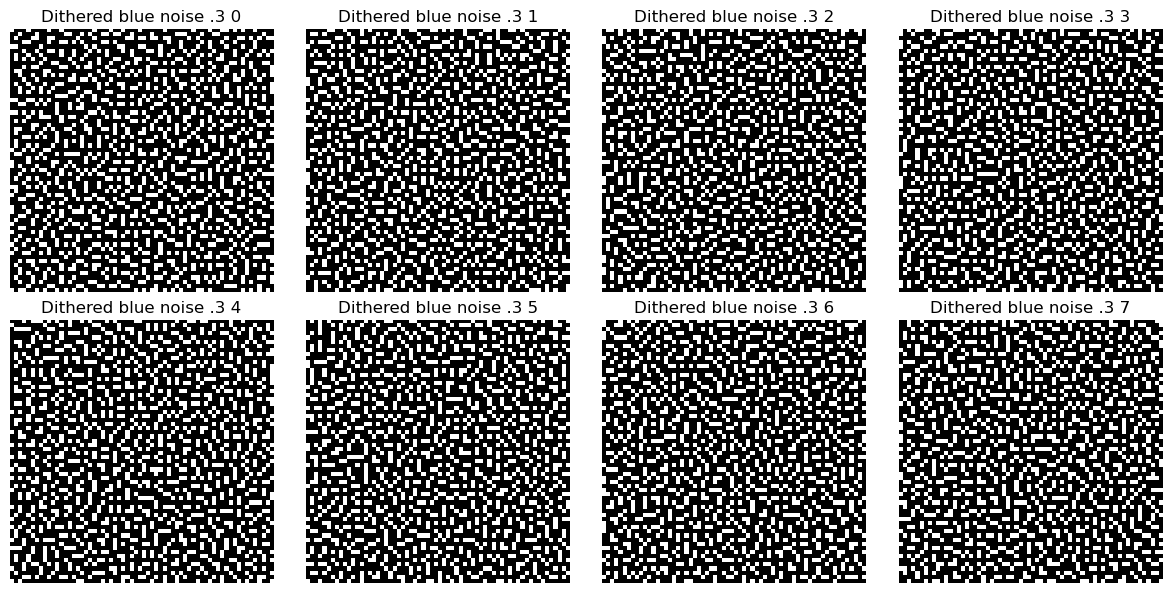

Wrote textures/bluenoise_filterinput/dither_point5\0.png
Wrote textures/bluenoise_filterinput/dither_point5\1.png
Wrote textures/bluenoise_filterinput/dither_point5\2.png
Wrote textures/bluenoise_filterinput/dither_point5\3.png
Wrote textures/bluenoise_filterinput/dither_point5\4.png
Wrote textures/bluenoise_filterinput/dither_point5\5.png
Wrote textures/bluenoise_filterinput/dither_point5\6.png
Wrote textures/bluenoise_filterinput/dither_point5\7.png


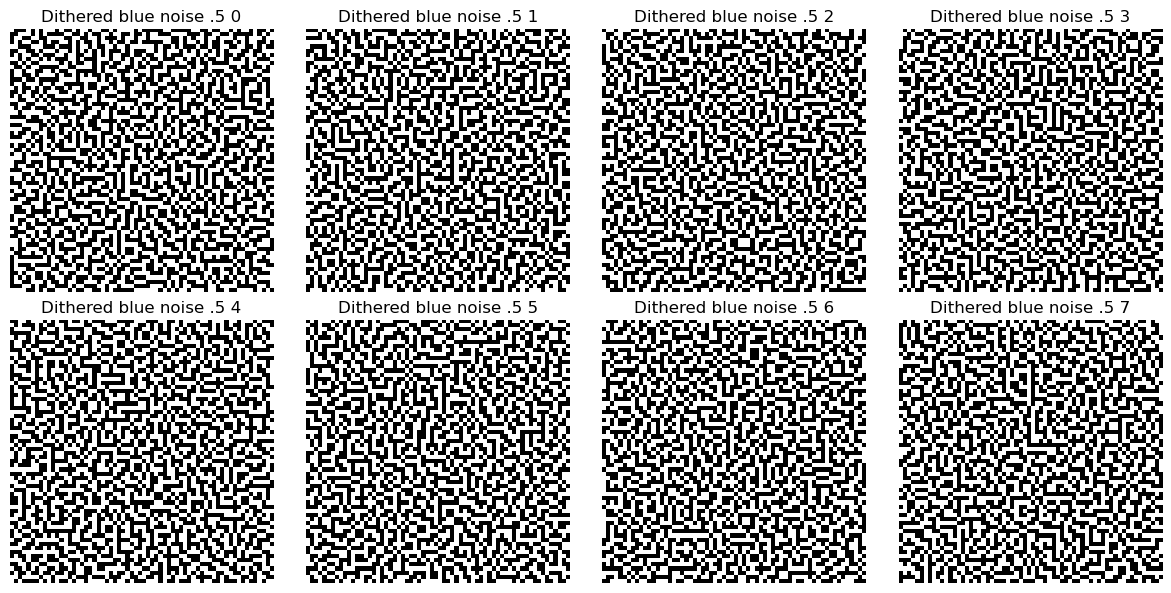

Wrote textures/bluenoise_filterinput/dither_point7\0.png
Wrote textures/bluenoise_filterinput/dither_point7\1.png
Wrote textures/bluenoise_filterinput/dither_point7\2.png
Wrote textures/bluenoise_filterinput/dither_point7\3.png
Wrote textures/bluenoise_filterinput/dither_point7\4.png
Wrote textures/bluenoise_filterinput/dither_point7\5.png
Wrote textures/bluenoise_filterinput/dither_point7\6.png
Wrote textures/bluenoise_filterinput/dither_point7\7.png


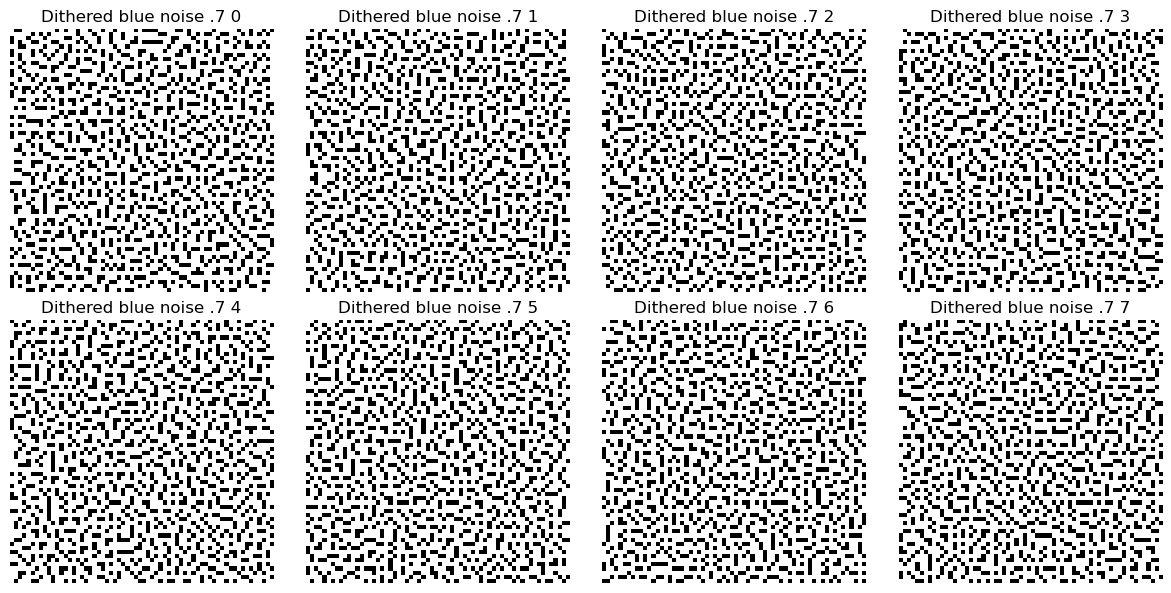

Wrote textures/bluenoise_filterinput/dither_point7\0.png
Wrote textures/bluenoise_filterinput/dither_point7\1.png
Wrote textures/bluenoise_filterinput/dither_point7\2.png
Wrote textures/bluenoise_filterinput/dither_point7\3.png
Wrote textures/bluenoise_filterinput/dither_point7\4.png
Wrote textures/bluenoise_filterinput/dither_point7\5.png
Wrote textures/bluenoise_filterinput/dither_point7\6.png
Wrote textures/bluenoise_filterinput/dither_point7\7.png


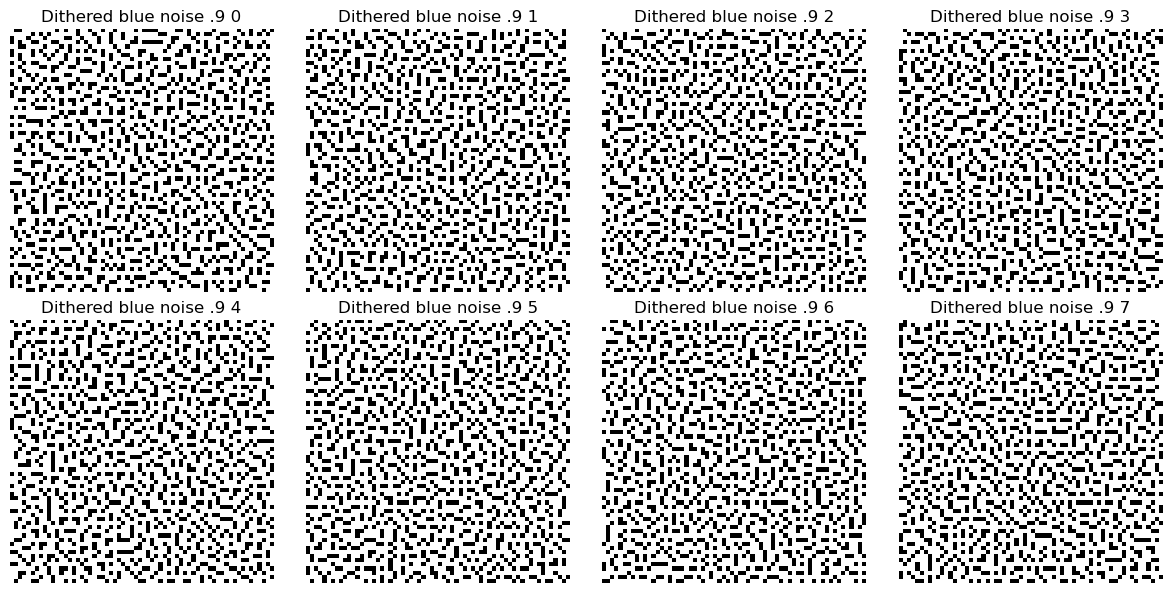

Wrote textures/white_noise/64x64/dither_point1\0.png
Wrote textures/white_noise/64x64/dither_point1\1.png
Wrote textures/white_noise/64x64/dither_point1\2.png
Wrote textures/white_noise/64x64/dither_point1\3.png
Wrote textures/white_noise/64x64/dither_point1\4.png
Wrote textures/white_noise/64x64/dither_point1\5.png
Wrote textures/white_noise/64x64/dither_point1\6.png
Wrote textures/white_noise/64x64/dither_point1\7.png


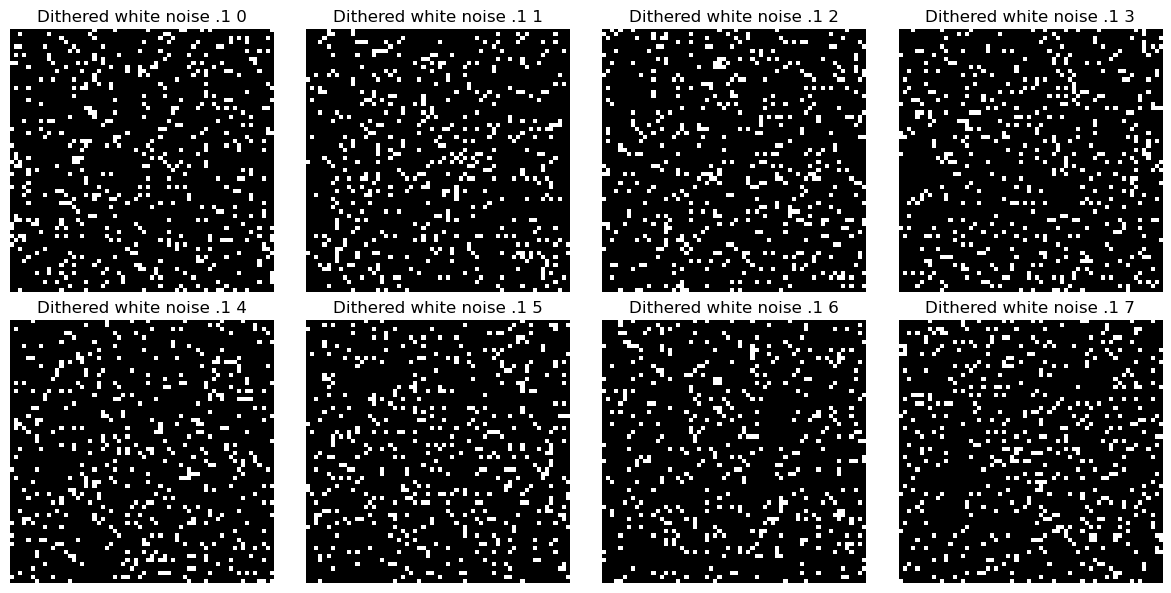

Wrote textures/white_noise/64x64/dither_point3\0.png
Wrote textures/white_noise/64x64/dither_point3\1.png
Wrote textures/white_noise/64x64/dither_point3\2.png
Wrote textures/white_noise/64x64/dither_point3\3.png
Wrote textures/white_noise/64x64/dither_point3\4.png
Wrote textures/white_noise/64x64/dither_point3\5.png
Wrote textures/white_noise/64x64/dither_point3\6.png
Wrote textures/white_noise/64x64/dither_point3\7.png


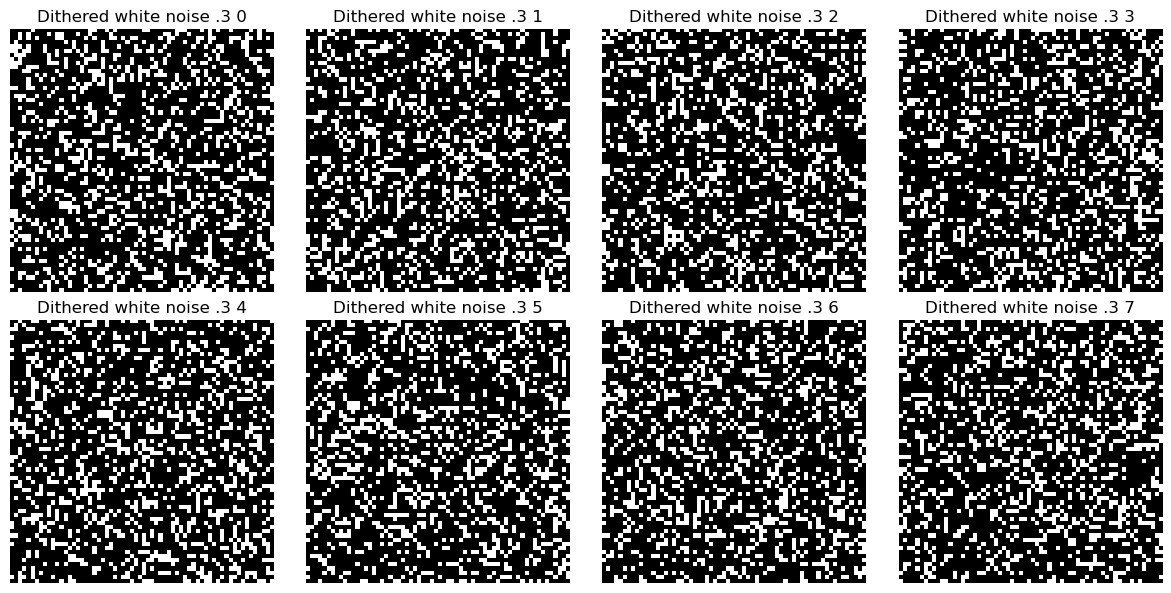

Wrote textures/white_noise/64x64/dither_point5\0.png
Wrote textures/white_noise/64x64/dither_point5\1.png
Wrote textures/white_noise/64x64/dither_point5\2.png
Wrote textures/white_noise/64x64/dither_point5\3.png
Wrote textures/white_noise/64x64/dither_point5\4.png
Wrote textures/white_noise/64x64/dither_point5\5.png
Wrote textures/white_noise/64x64/dither_point5\6.png
Wrote textures/white_noise/64x64/dither_point5\7.png


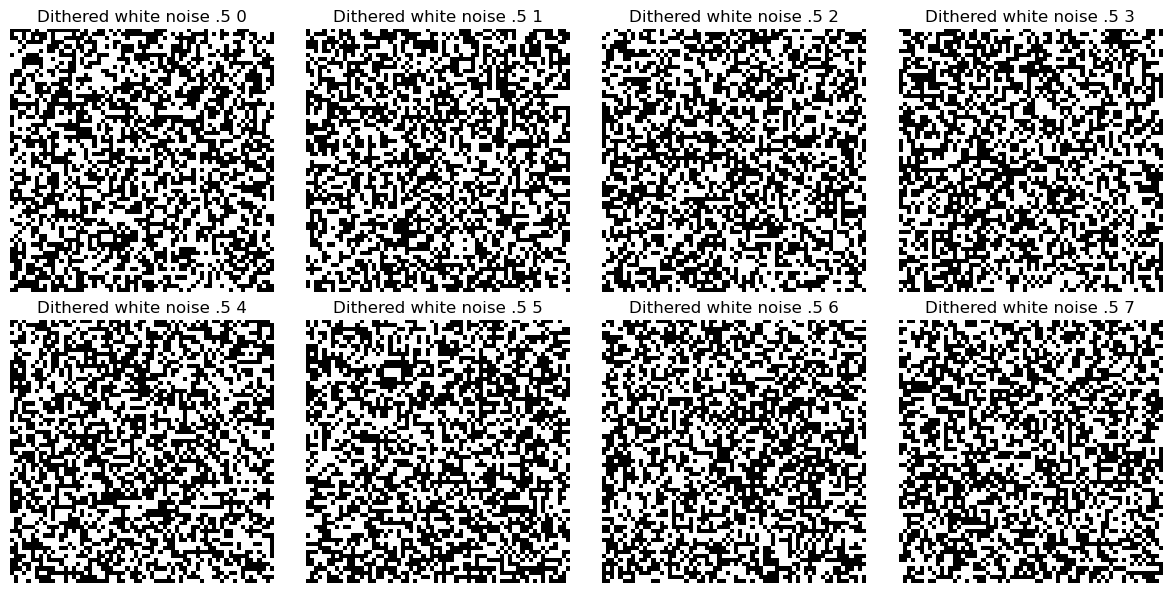

Wrote textures/white_noise/64x64/dither_point7\0.png
Wrote textures/white_noise/64x64/dither_point7\1.png
Wrote textures/white_noise/64x64/dither_point7\2.png
Wrote textures/white_noise/64x64/dither_point7\3.png
Wrote textures/white_noise/64x64/dither_point7\4.png
Wrote textures/white_noise/64x64/dither_point7\5.png
Wrote textures/white_noise/64x64/dither_point7\6.png
Wrote textures/white_noise/64x64/dither_point7\7.png


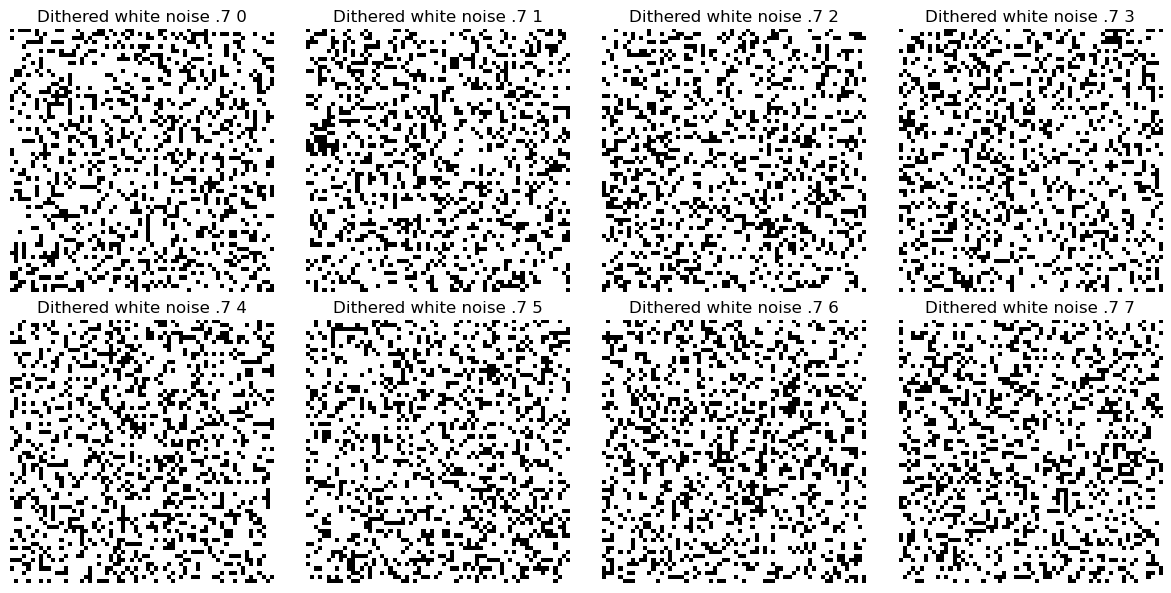

Wrote textures/white_noise/64x64/dither_point9\0.png
Wrote textures/white_noise/64x64/dither_point9\1.png
Wrote textures/white_noise/64x64/dither_point9\2.png
Wrote textures/white_noise/64x64/dither_point9\3.png
Wrote textures/white_noise/64x64/dither_point9\4.png
Wrote textures/white_noise/64x64/dither_point9\5.png
Wrote textures/white_noise/64x64/dither_point9\6.png
Wrote textures/white_noise/64x64/dither_point9\7.png


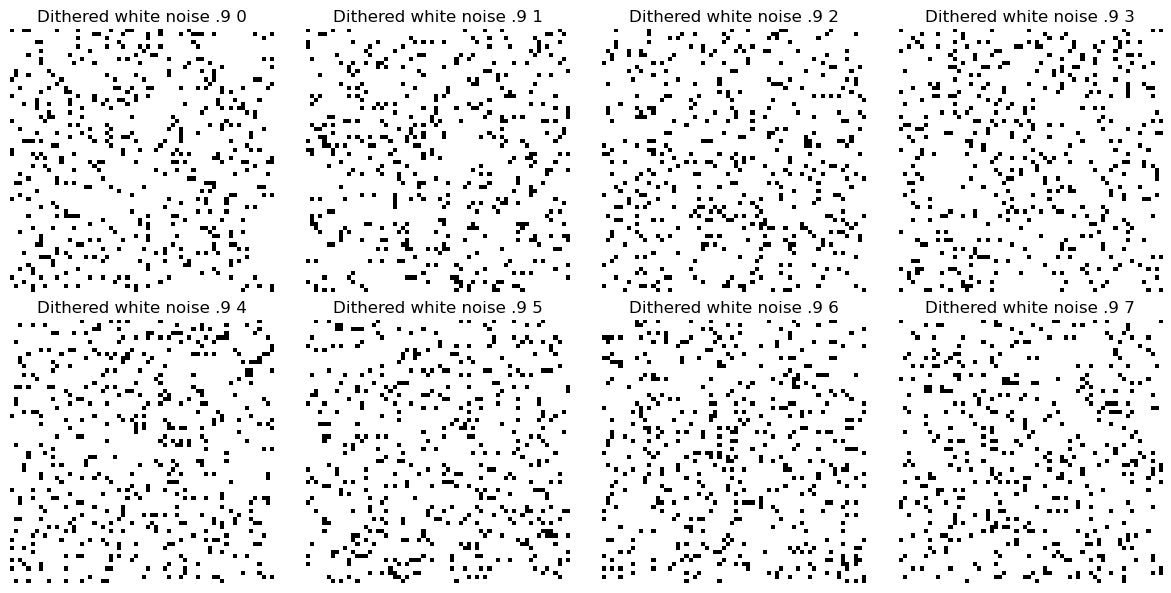

In [21]:
from src.noise import dither_with_noise, dither_with_noise2
# Dither our blue noise

# Make gray with varying brightness
gray_image_point1 = create_gray_image(shape = (64, 64), brightness = 0.1)
gray_image_point3 = create_gray_image(shape = (64, 64), brightness = 0.3)
gray_image_point5 = create_gray_image(shape = (64, 64), brightness = 0.5)
gray_image_point7 = create_gray_image(shape = (64, 64), brightness = 0.7)
gray_image_point9 = create_gray_image(shape = (64, 64), brightness = 0.9)


# Function to loop dithering

def dither_directory(
    input_dir="textures/bluenoise_filterinput",
    output_dir="textures/bluenoise_filterinput/dither_point3",
    gray_image = None,
    in_size = 64,
    names=tuple(str(i) for i in range(8)),
    noise_type_name = 'noisetype',
):
    os.makedirs(output_dir, exist_ok=True)

    if gray_image is None:
        print("Gray image is a required parameter and cannot be None!")
        return

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()

    for i, name in enumerate(names):
        src_path = os.path.join(input_dir, f"{name}.png")
        if not os.path.exists(src_path):
            print(f"Skipping {src_path} (not found).")
            continue

        img = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipping {src_path} (could not read).")
            continue
        
        img = normalize_to_unit_range(img)
        dithered_img = dither_with_noise(gray_image, img)
        dithered_img_uint8 = (dithered_img * 255).astype('uint8')
        
        out_path = os.path.join(output_dir, f"{name}.png")
        ok = cv2.imwrite(out_path, dithered_img_uint8)
        if ok:
            print(f"Wrote {out_path}")
        else:
            print(f"Failed to write {out_path}")
        
        if i < len(axes):
            axes[i].imshow(dithered_img, cmap='gray', vmin=0, vmax=1)
            axes[i].set_title(f"Dithered {noise_type_name} {name}")
            axes[i].axis('off')
    
    for j in range(len(names), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

dither_directory(
    input_dir = "textures/bluenoise_filterinput",
    output_dir = "textures/bluenoise_filterinput/dither_point1",
    gray_image = gray_image_point1,
    noise_type_name = 'blue noise .1'
)

dither_directory(
    input_dir = "textures/bluenoise_filterinput",
    output_dir = "textures/bluenoise_filterinput/dither_point3",
    gray_image = gray_image_point3,
    noise_type_name = 'blue noise .3'
)

dither_directory(
    input_dir = "textures/bluenoise_filterinput",
    output_dir = "textures/bluenoise_filterinput/dither_point5",
    gray_image = gray_image_point5,
    noise_type_name = 'blue noise .5'
)

dither_directory(
    input_dir = "textures/bluenoise_filterinput",
    output_dir = "textures/bluenoise_filterinput/dither_point7",
    gray_image = gray_image_point7,
    noise_type_name = 'blue noise .7'
)

dither_directory(
    input_dir = "textures/bluenoise_filterinput",
    output_dir = "textures/bluenoise_filterinput/dither_point7",
    gray_image = gray_image_point7,
    noise_type_name = 'blue noise .9'
)

dither_directory(
    input_dir = "textures/white_noise/64x64/",
    output_dir = "textures/white_noise/64x64/dither_point1",
    gray_image = gray_image_point1,
    noise_type_name = 'white noise .1'
)

dither_directory(
    input_dir = "textures/white_noise/64x64/",
    output_dir = "textures/white_noise/64x64/dither_point3",
    gray_image = gray_image_point3,
    noise_type_name = 'white noise .3'
)

dither_directory(
    input_dir = "textures/white_noise/64x64/",
    output_dir = "textures/white_noise/64x64/dither_point5",
    gray_image = gray_image_point5,
    noise_type_name = 'white noise .5'
)

dither_directory(
    input_dir = "textures/white_noise/64x64/",
    output_dir = "textures/white_noise/64x64/dither_point7",
    gray_image = gray_image_point7,
    noise_type_name = 'white noise .7'
)

dither_directory(
    input_dir = "textures/white_noise/64x64/",
    output_dir = "textures/white_noise/64x64/dither_point9",
    gray_image = gray_image_point9,
    noise_type_name = 'white noise .9'
)


The best looking ones were dithered against 0.3 luminance. Now we can tile them to check how they look tiled.

In [22]:

make_tiled_versions_cv2(
	"textures/white_noise/64x64/dither_point3",
	"textures/white_noise/64x64/dither_point3/tiled",
	out_size = 1024)

make_tiled_versions_cv2(
	"textures/bluenoise_filterinput/dither_point3",
	"textures/bluenoise_filterinput/dither_point3/tiled",
	out_size = 1024)

Wrote textures/white_noise/64x64/dither_point3/tiled\tiled0.png
Wrote textures/white_noise/64x64/dither_point3/tiled\tiled1.png
Wrote textures/white_noise/64x64/dither_point3/tiled\tiled2.png
Wrote textures/white_noise/64x64/dither_point3/tiled\tiled3.png
Wrote textures/white_noise/64x64/dither_point3/tiled\tiled4.png
Wrote textures/white_noise/64x64/dither_point3/tiled\tiled5.png
Wrote textures/white_noise/64x64/dither_point3/tiled\tiled6.png
Wrote textures/white_noise/64x64/dither_point3/tiled\tiled7.png
Wrote textures/bluenoise_filterinput/dither_point3/tiled\tiled0.png
Wrote textures/bluenoise_filterinput/dither_point3/tiled\tiled1.png
Wrote textures/bluenoise_filterinput/dither_point3/tiled\tiled2.png
Wrote textures/bluenoise_filterinput/dither_point3/tiled\tiled3.png
Wrote textures/bluenoise_filterinput/dither_point3/tiled\tiled4.png
Wrote textures/bluenoise_filterinput/dither_point3/tiled\tiled5.png
Wrote textures/bluenoise_filterinput/dither_point3/tiled\tiled6.png
Wrote textur

It becomes slightly apparent, if you look correctly, that the blue noise dithering is tiled; but it is shockingly so that the white noise is tiled. This still is a win for blue noise.